<a href="https://colab.research.google.com/github/Alirzeanoroozi/deep_learning_codes/blob/main/new_Federate_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [3]:
train_dataset = MNIST('./', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('./', train=False, download=True, transform=transforms.ToTensor())

train_dataset, dev_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.83), int(len(train_dataset) * 0.17)])

In [21]:
total_train_size = len(train_dataset)
total_test_size = len(test_dataset)
total_dev_size = len(dev_dataset)

classes = 10
input_dim = 784

num_clients = 4
rounds = 10
batch_size = 128
epochs_per_client = 3
learning_rate = .001

In [22]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
      return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
  def __init__(self, dl, device):
      self.dl = dl
      self.device = device

  def __iter__(self):
      for batch in self.dl:
          yield to_device(batch, self.device)

  def __len__(self):
      return len(self.dl)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [23]:
class FederatedNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 20, 7)
        self.conv2 = torch.nn.Conv2d(20, 40, 7)
        self.maxpool = torch.nn.MaxPool2d(2, 2)
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(2560, 10)
        self.non_linearity = torch.nn.functional.relu
        self.track_layers = {'conv1': self.conv1, 'conv2': self.conv2, 'linear': self.linear}

    def forward(self, x_batch):
        out = self.conv1(x_batch)
        out = self.non_linearity(out)
        out = self.conv2(out)
        out = self.non_linearity(out)
        out = self.maxpool(out)
        out = self.flatten(out)
        out = self.linear(out)
        return out

    def apply_parameters(self, parameters_dict):
        with torch.no_grad():
            for layer_name in parameters_dict:
                self.track_layers[layer_name].weight.data = parameters_dict[layer_name]['weight']
                self.track_layers[layer_name].bias.data = parameters_dict[layer_name]['bias']

    def get_parameters(self):
        parameters_dict = dict()
        for layer_name in self.track_layers:
            parameters_dict[layer_name] = {
                'weight': self.track_layers[layer_name].weight.data,
                'bias': self.track_layers[layer_name].bias.data
            }
        return parameters_dict

    def fit(self, dataset, epochs, lr, batch_size=128, opt=torch.optim.SGD):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = opt(self.parameters(), lr)

        history = []
        for epoch in range(epochs):
            losses = []
            accs = []
            for batch in dataloader:
                images, labels = batch
                outputs = self(images)
                loss = torch.nn.functional.cross_entropy(outputs, labels)
                with torch.no_grad():
                    _, predictions = torch.max(outputs, dim=1)
                    acc = torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss.detach()

                losses.append(loss)
                accs.append(acc)

            avg_loss = torch.stack(losses).mean().item()
            avg_acc = torch.stack(accs).mean().item()
            history.append((avg_loss, avg_acc))
        return history

    def evaluate(self, dataset, batch_size=128):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
            for batch in dataloader:

                images, labels = batch
                outputs = self(images)
                loss = torch.nn.functional.cross_entropy(outputs, labels)
                with torch.no_grad():
                    _, predictions = torch.max(outputs, dim=1)
                    acc = torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

                losses.append(loss)
                accs.append(acc)

        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc)

In [24]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset
        self.net = to_device(FederatedNet(), device)

    def update_parameters(self, parameters_dict):
        self.net.apply_parameters(parameters_dict)
        train_history = self.net.fit(self.dataset, epochs_per_client, learning_rate, batch_size)
        print('{}: Loss = {}, Accuracy = {}'.format(self.client_id, round(train_history[-1][0], 4), round(train_history[-1][1], 4)))
        return self.net.get_parameters()

    def evaluate(self, dataset, batch_size=128):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
            for batch in dataloader:

                images, labels = batch
                outputs = self.net(images)
                loss = torch.nn.functional.cross_entropy(outputs, labels)
                with torch.no_grad():
                    _, predictions = torch.max(outputs, dim=1)
                    acc = torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

                losses.append(loss)
                accs.append(acc)

        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc)

In [25]:
examples_per_client = total_train_size // num_clients
client_datasets = random_split(train_dataset, [min(i + examples_per_client, total_train_size) - i for i in range(0, total_train_size, examples_per_client)])
clients = [Client('client_' + str(i), client_datasets[i]) for i in range(num_clients)]

In [26]:
global_net = to_device(FederatedNet(), device)

history = []
for i in range(rounds):
    print('Start Round {} ...'.format(i + 1))
    curr_parameters = global_net.get_parameters()
    new_parameters = dict([(layer_name, {'weight': 0, 'bias': 0}) for layer_name in curr_parameters])

    parameters_and_weights = [(client.update_parameters(curr_parameters), client.evaluate(dev_dataset)[0]) for client in clients]
    w_sum = 0
    for w in parameters_and_weights:
      w_sum += (1 / w[1])

    for client_parameters, fraction in parameters_and_weights:
        for layer_name in client_parameters:
                new_parameters[layer_name]['weight'] += (1 / fraction) * (1 / w_sum) * client_parameters[layer_name]['weight']
                new_parameters[layer_name]['bias'] += (1 / fraction) * (1 / w_sum) * client_parameters[layer_name]['bias']

    global_net.apply_parameters(new_parameters)

    train_loss, train_acc = global_net.evaluate(train_dataset)
    dev_loss, dev_acc = global_net.evaluate(dev_dataset)
    print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n'.format(i + 1, round(train_loss, 4), round(dev_loss, 4), round(dev_acc, 4)))
    history.append((train_loss, dev_loss))

Start Round 1 ...
client_0: Loss = 2.2314, Accuracy = 0.4529
client_1: Loss = 2.0011, Accuracy = 0.7244
client_2: Loss = 1.2067, Accuracy = 0.768
client_3: Loss = 0.659, Accuracy = 0.8339
After round 1, train_loss = 0.6242, dev_loss = 0.6211, dev_acc = 0.8429

Start Round 2 ...
client_0: Loss = 0.5135, Accuracy = 0.863
client_1: Loss = 0.4651, Accuracy = 0.8675
client_2: Loss = 0.4362, Accuracy = 0.8762
client_3: Loss = 0.4054, Accuracy = 0.8826
After round 2, train_loss = 0.4066, dev_loss = 0.3963, dev_acc = 0.8871

Start Round 3 ...
client_0: Loss = 0.3944, Accuracy = 0.8867
client_1: Loss = 0.3871, Accuracy = 0.8844
client_2: Loss = 0.3755, Accuracy = 0.8923
client_3: Loss = 0.3568, Accuracy = 0.8948
After round 3, train_loss = 0.3647, dev_loss = 0.3532, dev_acc = 0.8996

Start Round 4 ...
client_0: Loss = 0.3488, Accuracy = 0.9013
client_1: Loss = 0.3467, Accuracy = 0.896
client_2: Loss = 0.341, Accuracy = 0.9024
client_3: Loss = 0.3244, Accuracy = 0.9043
After round 4, train_loss 

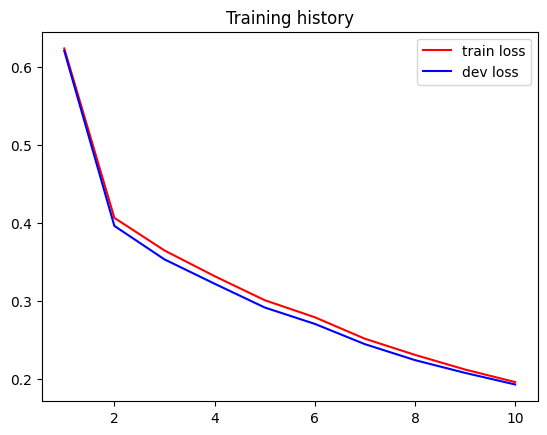

In [27]:
plt.plot([i + 1 for i in range(len(history))], [history[i][0] for i in range(len(history))], color='r', label='train loss')
plt.plot([i + 1 for i in range(len(history))], [history[i][1] for i in range(len(history))], color='b', label='dev loss')
plt.legend()
plt.title('Training history')
plt.show()

In [28]:
test_loss, test_acc = global_net.evaluate(test_dataset)
test_acc

0.9488726258277893

In [ ]:
global_net = to_device(FederatedNet(), device)
history = []
for i in range(rounds):
    print('Start Round {} ...'.format(i + 1))
    curr_parameters = global_net.get_parameters()
    new_parameters = dict([(layer_name, {'weight': 0, 'bias': 0}) for layer_name in curr_parameters])
    r = torch.randn(8)
    fractions = [ i/sum(r) for i in r ]
    for client, fraction in zip(clients, fractions):
        client_parameters = client.train(curr_parameters)
        for layer_name in client_parameters:
            new_parameters[layer_name]['weight'] += fraction * client_parameters[layer_name]['weight']
            new_parameters[layer_name]['bias'] += fraction * client_parameters[layer_name]['bias']
    global_net.apply_parameters(new_parameters)

    train_loss, train_acc = global_net.evaluate(train_dataset)
    dev_loss, dev_acc = global_net.evaluate(dev_dataset)
    print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n'.format(i + 1, round(train_loss, 4),
            round(dev_loss, 4), round(dev_acc, 4)))
    history.append((train_loss, dev_loss))

Start Round 1 ...
client_0: Loss = 2.2788, Accuracy = 0.188
client_1: Loss = 2.2392, Accuracy = 0.481
client_2: Loss = 2.1801, Accuracy = 0.6002
client_3: Loss = 2.0606, Accuracy = 0.6273
client_4: Loss = 1.8502, Accuracy = 0.6607
client_5: Loss = 1.4993, Accuracy = 0.7102
client_6: Loss = 1.1246, Accuracy = 0.7599
client_7: Loss = 0.863, Accuracy = 0.7957
After round 1, train_loss = 2.2982, dev_loss = 2.2976, dev_acc = 0.1483

Start Round 2 ...
client_0: Loss = 2.2916, Accuracy = 0.2052
client_1: Loss = 2.2814, Accuracy = 0.2488
client_2: Loss = 2.2694, Accuracy = 0.2695
client_3: Loss = 2.2524, Accuracy = 0.32
client_4: Loss = 2.2332, Accuracy = 0.3599
client_5: Loss = 2.2032, Accuracy = 0.3897
client_6: Loss = 2.1551, Accuracy = 0.4088
client_7: Loss = 2.0805, Accuracy = 0.4247
After round 2, train_loss = 2.2577, dev_loss = 2.2571, dev_acc = 0.3394

Start Round 3 ...
client_0: Loss = 2.2397, Accuracy = 0.3614
client_1: Loss = 2.21, Accuracy = 0.3775
client_2: Loss = 2.1693, Accuracy

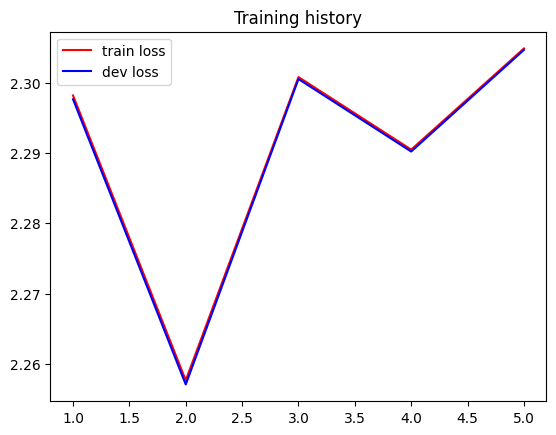

In [ ]:
plt.plot([i + 1 for i in range(len(history))], [history[i][0] for i in range(len(history))], color='r', label='train loss')
plt.plot([i + 1 for i in range(len(history))], [history[i][1] for i in range(len(history))], color='b', label='dev loss')
plt.legend()
plt.title('Training history')
plt.show()